<a href="https://colab.research.google.com/github/karimamd/Bone-Abnormality-Classifier-in-Keras/blob/Khaled-Branch/Ensemble_Ready_Feature_conct.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# !wget -c https://cs.stanford.edu/group/mlgroup/MURA-v1.1.zip

--2019-01-18 14:41:10--  https://cs.stanford.edu/group/mlgroup/MURA-v1.1.zip
Resolving cs.stanford.edu (cs.stanford.edu)... 171.64.64.64
Connecting to cs.stanford.edu (cs.stanford.edu)|171.64.64.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3380245855 (3.1G) [application/zip]
Saving to: ‘MURA-v1.1.zip’

MURA-v1.1.zip         2%[                    ]  80.01M  9.14MB/s    eta 4m 52s ^C


In [0]:
import os
from IPython.display import clear_output
import zipfile
import time
import concurrent.futures

# timer func evaluates func/s running time in minutes
def timer(f):

    def inner(*args, **kwargs):
        try:
            t0 = time.time()
            return f(*args, **kwargs)
        finally:
            t1 = time.time()
            print(f.__name__, 'executed in', (t1 - t0) / 60, ' min/s')

    return inner

# fast unzip, usually 900% faster than normal "unzip" command
# thanks to Peter Bengtsson <3: https://www.peterbe.com/

@timer
def fast_unzip(fn, dest):

    def unzip_member(zf, name, dest):
        while True:
            try:
                zf.extract(name, dest)
                break
            except OSError as e:
                if e.errno != os.errno.EEXIST:
                    raise
                time.sleep(2)
                pass

    with open(fn, 'rb') as f:
        zf = zipfile.ZipFile(f)
        futures = []
        with concurrent.futures.ThreadPoolExecutor() as executor:
            for member in zf.infolist():
                futures.append(executor.submit(unzip_member, zf,
                               member.filename, dest))

            for future in concurrent.futures.as_completed(futures):
                future.result()

In [0]:
fast_unzip('MURA-v1.1.zip','/content')
!rm MURA-v1.1.zip

fast_unzip executed in 8.018811543782552e-06  min/s


FileNotFoundError: ignored

In [0]:
!pip uninstall keras -y
!pip3 install git+https://github.com/keras-team/keras
!pip uninstall keras-preprocessing -y
!pip3 install git+https://github.com/keras-team/keras-preprocessing
clear_output()

In [0]:
# # to force restart runtime
# def restart_runtime():
#   os.kill(os.getpid(), 9)
  
# try:
#     restart_runtime
# except NameError:
#     print("already restarted!")
# else:
#     restart_runtime()

In [0]:
import pandas as pd
import numpy as np
import os, time, signal, shutil
import multiprocessing as mp
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
from tqdm import tqdm
import keras
from keras.applications.mobilenetv2 import MobileNetV2
from keras.applications.densenet import DenseNet169
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet50 import ResNet50
from keras.applications.nasnet import NASNetMobile
from keras.applications.xception import Xception
from keras.preprocessing import image
from keras.applications.mobilenetv2 import preprocess_input
from keras.applications import MobileNet
from keras.callbacks import (EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard)
from keras.layers import Dense, GlobalAveragePooling2D, Input,Flatten
from keras.metrics import binary_accuracy, binary_crossentropy
from keras.models import Model, Sequential
from keras.optimizers import SGD, Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenetv2 import MobileNetV2
from keras.preprocessing import image as k_im_prep
from keras import backend as K
from keras_preprocessing.image import ImageDataGenerator
from keras.models import load_model
from keras.layers.merge import concatenate
from keras.utils import plot_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from sklearn.metrics import confusion_matrix
import itertools

Using TensorFlow backend.


In [0]:
total_size = 0
# to get size of certain directory
for path, dirs, files in os.walk('MURA-v1.1'):
    for f in files:
        fp = os.path.join(path, f)
        total_size += os.path.getsize(fp)
print("Directory size: " + str(total_size/1024**3) + " (Gigabyte)")

Directory size: 3.1397332791239023 (Gigabyte)


In [0]:
drivee=""


In [0]:
# from os import listdir
# from os.path import isfile, join
# onlyfiles = [f for f in listdir("MURA-v1.1")]
# print(onlyfiles)

In [0]:
#@title Directory of saved models { form-width: "30%", display-mode: "both" }

''' select "unique name" for "your" models directory where pre-trained/saved
models will be uploaded to Dropbox if you want to apply any modifications 
such as preprocessing '''

dir = "khalodmodels" #@param {type:"string"}
dir = dir + "/"

# SETUP 
### just run all cells in this section

In [0]:
# just run the cell to be able to upload and download from Dropbox
!git clone https://github.com/thatbrguy/Dropbox-Uploader.git
!chmod +x Dropbox-Uploader/dropbox_uploader.sh
source = 'Dropbox-Uploader'
dest1 = '/content'
shutil.move(source+'/'+'dropbox_uploader.sh', dest1)
!echo "pzFqTa1uWVAAAAAAAAAACtGcVohdBzoFRrwtLYsQCxhD9a7IjevvuOTNV8OWB2LX" > token.txt

fatal: destination path 'Dropbox-Uploader' already exists and is not an empty directory.
chmod: cannot access 'Dropbox-Uploader/dropbox_uploader.sh': No such file or directory


Error: ignored

In [0]:
!bash dropbox_uploader.sh download README.md > log.txt

In [0]:
# download train and valid csv files that include images path and their labels
!bash dropbox_uploader.sh -p download /labels_csv/train_paths_labels.csv
!bash dropbox_uploader.sh -p download /labels_csv/valid_paths_labels.csv

# create folder of pre-trained/saved models if it doesn't exist
os.system("bash dropbox_uploader.sh mkdir /"+ dir[:-1] +" > log.txt")

# download folder of pre-trained/saved models
os.system("bash dropbox_uploader.sh download "+ dir[:-1])

> Skipping file "/labels_csv/train_paths_labels.csv", file exists with the same hash
> Skipping file "/labels_csv/valid_paths_labels.csv", file exists with the same hash


0

In [0]:
# watch_ monitors the state of certain file if it is modified and uploads it to Dropbox if so
def watch_(file, interval):
    first_Time = False
    while True:
        if os.path.isfile(dir + file):
            if not first_Time:
                os.system('bash dropbox_uploader.sh upload ' + dir
                          + file + ' ' + dir + file)
                first_Time = True
                
            moddate = os.stat(dir + file)[8]
            time.sleep(interval)
            moddate_ = os.stat(dir + file)[8]
            
            if moddate < moddate_:
                os.system('bash dropbox_uploader.sh upload ' + dir
                          + file + ' ' + dir + file)
        else:
            time.sleep(interval)
      

In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [0]:
def paths_n_labels(csv):
    #make dataframe
    print(csv)
    studies=pd.read_csv(csv, sep=',',header=None)
    #separate study paths and labels of given limp from those of other limps
    limp_studies=studies[studies[0].str.contains("Khalodaaa")==False]
    #make it a numpy
    limp_studies=np.array(limp_studies)
    #limp study folder paths
    limp_paths=[]
    #labels of given limp
    limp_labels=[]
    for i in tqdm( range(limp_studies.shape[0]) ):
        study_path= drivee + limp_studies[i][0]
        study_label=limp_studies[i][1]
        study_files = [f for f in listdir(study_path) if isfile(join(study_path, f))]
        for image in study_files:
            limp_paths.append(study_path + image)
            limp_labels.append(study_label)

    limp_paths=np.array(limp_paths)
    limp_labels=np.array(limp_labels)

    return limp_paths,limp_labels

In [0]:
def read_images(paths ,targ_size= (224, 224)):
    images=[]
    #load any limp images
    for path in tqdm(paths):
        img=k_im_prep.load_img(path, target_size=targ_size )
        images.append(np.array(img))

    #making it a numpy array instead of python list
    return (np.array(images))

# MODEL

In [0]:
def make_FT_model(base=1, imagenet=True, freeze_all=True, add_denses=True):
  
  #weights of pretrained model
  if (imagenet==True):
    w='imagenet'
  else:
    w=None
  
  #default because refrenced before assignment error, just scroll down
  base_model = MobileNetV2(input_shape= (224, 224, 3),weights=w, include_top=False)

#   feature_Concatenation_Merged=None
  #initializing pretrained model
  
  print("Choose model is",base)
  
  if (base==0):
    base_model = MobileNetV2(input_shape= (224, 224, 3),weights=w, include_top=False)
  elif (base == 1):
    base_model = DenseNet169(input_shape= (224, 224, 3),weights=w, include_top=False)
  elif (base == 2):
    base_model = InceptionV3(input_shape= (224, 224, 3),weights=w, include_top=False)
  elif (base == 3):
    base_model = ResNet50(input_shape= (224, 224, 3),weights=w, include_top=False)   
  elif (base == 4):
    base_model = NASNetMobile(input_shape= (224, 224, 3),weights=w, include_top=False)
  elif (base == 6): #Feature concatenated
    base_model_new = Input(shape= (224, 224, 3))  
 
  if (freeze_all):
    #freeze layers of densenet
    for layer in base_model.layers:
      layer.trainable= False 
  


  if(add_denses):
    

    if(base ==6):  #Feature concatenated
      
      print("Adding bases")
      feature_Concatenation_model1=NASNetMobile(input_shape= (224, 224, 3),weights=w, include_top=False, input_tensor=base_model_new)
      feature_Concatenation_model2=MobileNetV2(input_shape= (224, 224, 3),weights=w, include_top=False, input_tensor=base_model_new)
      feature_Concatenation_model3=ResNet50(input_shape= (224, 224, 3),weights=w, include_top=False, input_tensor=base_model_new)

      x1 = feature_Concatenation_model1.output
      x1 = GlobalAveragePooling2D()(x1)
   
      x2 = feature_Concatenation_model2.output
      x2 = GlobalAveragePooling2D()(x2)
      
      x3 = feature_Concatenation_model2.output
      x3 = GlobalAveragePooling2D()(x3)
      
 

      merge = concatenate([x1, x2, x3])
      
      
      merge = Dense(512, activation='relu')(merge)
      merge = Dense(128, activation='relu')(merge)
      
      predictions = Dense(1, activation='sigmoid')(merge)
      
      print("Model Creation")

      feature_Concatenation_Merged = Model(inputs=[base_model_new],outputs=predictions)
      model= feature_Concatenation_Merged
      print("all here done")

      
    else:
            
      # add a global spatial average pooling layer
      x = base_model.output
      x = GlobalAveragePooling2D()(x)
      
      # let's add a fully-connected layer
      #x = Dense(1024, activation='relu')(x)
      x = Dense(512, activation='relu')(x)
      x = Dense(128, activation='relu')(x)
      #x = Dense(32, activation='relu')(x)
      # and a logistic layer -- let's say we have 200 classes

      predictions = Dense(1, activation='sigmoid')(x)

      # this is the model we will train
      model = Model(inputs=base_model.input, outputs=predictions)
    
  else:
    # just feature extractor
    model = Model(inputs=base_model.input, output=x)
  
  
  plot_model(model,to_file='demo.png',show_shapes=True)
#   SVG(model_to_dot(model).create(prog='’'dot’, format=’svg’))
#   print(model.summary())

  return model

In [0]:
models_names=['MobileNetV2','DenseNet169','InceptionV3','ResNet50','NASNetMobile','Xception','Feature_Conct']

In [0]:
# from keras.models import load_model

# @timer
# def evaluate_limps(model=1,epoch=5,batch=32, imagenet=True, freeze_all=False,verbose=2):
  
  
#   model_file= 'model_'+models_names[model]+'.h5'
  
#   df_train=pd.read_csv('train_paths_labels.csv')
#   df_valid=pd.read_csv('valid_paths_labels.csv')
  
#   datagen=ImageDataGenerator(rescale=1./255)
#   train_generator=datagen.flow_from_dataframe(dataframe=df_train, directory=None,x_col="Img_Path", y_col="Label", class_mode="binary", target_size=(224,224), batch_size=batch)
#   valid_generator=datagen.flow_from_dataframe(dataframe=df_valid, directory=None,x_col="Img_Path", y_col="Label", class_mode="binary", target_size=(224,224), batch_size=batch)
  
#   keras.backend.clear_session()
  
  
#   if not os.path.isfile(dir+model_file):
#     print("making model")
#     model=make_FT_model(base= model, imagenet=imagenet, freeze_all=freeze_all, add_denses=True)
#   else:
#     print("loading saved model")
#     model= load_model(dir+model_file)
  
#   print("compiling")
#   model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  
#   checkpoint= ModelCheckpoint(dir+model_file, monitor='val_loss', verbose=1, save_best_only=False,
#                               save_weights_only=False, mode='auto', period=1)
#   callbacks_list = [checkpoint]
    
#   step_train=train_generator.n//train_generator.batch_size
#   step_valid=valid_generator.n//valid_generator.batch_size
  
#   model.fit_generator(generator=train_generator, steps_per_epoch=step_train, epochs=epoch, validation_data=valid_generator,
#                       validation_steps=step_valid, shuffle=True, verbose=verbose, callbacks=callbacks_list)
  
  
  
#   loss_tr, accuracy_tr =model.evaluate_generator(train_generator, use_multiprocessing=True,workers=5,steps=step_train)
#   print("training loss/accuracy: ", loss_tr,'/', accuracy_tr)

#   loss_val, accuracy_val = model.evaluate_generator(valid_generator, use_multiprocessing=True,workers=5,steps=step_valid)
#   print("validation loss/accuracy: ", loss_val,'/', accuracy_val)

# Kareem's eval function

In [0]:
#KAREEM'S COPY OF FUNCTION JUST COMMENT THE CELL AND EVERYTHING IS NORMAL
def evaluate_limps(model=1,epoch=5,batch=32, imagenet=True, freeze_all=False,verbose=2):
  
  df_train=pd.read_csv('train_paths_labels.csv')
  df_valid=pd.read_csv('valid_paths_labels.csv')
  
  datagen = ImageDataGenerator(  rescale=1./255,
    featurewise_center=True,  #CHANGED IT TO TRUE # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=True,  #CHANGED IT TO TRUE# divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=30,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False,
    zoom_range=0.1,
    channel_shift_range=0.,
    fill_mode='nearest')
  
  datagen.mean = np.array([0.485, 0.456, 0.406], dtype=np.float32).reshape((1,1,3)) # ordering: [R, G, B]
  datagen.std  = np.array([0.229, 0.224, 0.225], dtype=np.float32).reshape((1,1,3)) # ordering: [R, G, B]
  train_generator=datagen.flow_from_dataframe(dataframe=df_train, directory=None,x_col="Img_Path",
                                              y_col="Label", class_mode="binary", target_size=(224,224), batch_size=batch)
  valid_generator=datagen.flow_from_dataframe(dataframe=df_valid, directory=None,x_col="Img_Path",
                                              y_col="Label", class_mode="binary", target_size=(224,224), batch_size=batch)
  print(len(train_generator))
  print("making model")
  if not os.path.isfile(model_file):
    model=make_FT_model(base= model, imagenet=imagenet, freeze_all=freeze_all, add_denses=True)
  else:
    model= load_model(model_file, compile=False)
  
  print("compiling")
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  
  checkpoint= ModelCheckpoint(model_file, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
  callbacks_list = [checkpoint]
    
  step_train=train_generator.n//train_generator.batch_size
  step_valid=valid_generator.n//valid_generator.batch_size
  model.fit_generator(generator=train_generator, steps_per_epoch=step_train, epochs=epoch,
                      validation_data=valid_generator, validation_steps=step_valid, shuffle=True,
                      verbose=verbose, callbacks=callbacks_list)
 
  
  #Confession matrix part
   ###########################################
  
  num_of_test_samples=3197
  train_studies=drivee+'MURA-v1.1/train_labeled_studies.csv'
  valid_studies=drivee+'MURA-v1.1/valid_labeled_studies.csv'
  
  
  valid_paths,valid_labels=paths_n_labels(valid_studies)
#   train_paths,train_labels=paths_n_labels(train_studies)

#   train_imgs= read_images(train_paths)
  valid_imgs= read_images(valid_paths)


  
  y_pred=model.predict(valid_imgs)
  y_pred[y_pred >=0.5]=1
  y_pred[y_pred <0.5]=0


#   y_pred_for_training=model.predict(train_imgs)
#   y_pred_for_training[y_pred_for_training >=0.5]=1
#   y_pred_for_training[y_pred_for_training < 0.5]=0


  print("second prediction vlayes")
  print(y_pred)

  # Compute confusion matrix
  cnf_matrix = confusion_matrix(valid_labels, y_pred)

#   cnf_matrix2 = confusion_matrix(train_labels, y_pred_for_training)
  
  plot_matrix_multiples(cnf_matrix,Name='Confusion matrix for valiadation set')
  
#   plot_matrix_multiples(cnf_matrix2,Name='Confusion matrix for training set')

  
    
  ###########################################
  loss_tr, accuracy_tr =model.evaluate_generator(train_generator, use_multiprocessing=True,steps=step_train)
  print("training loss/accuracy: ", loss_tr,'/', accuracy_tr)

  loss_val, accuracy_val = model.evaluate_generator(valid_generator, use_multiprocessing=True,steps=step_valid)
  print("validation loss/accuracy: ", loss_val,'/', accuracy_val)
    
    

In [0]:
!bash dropbox_uploader.sh upload model_Feature_Conct.h5 khalodmodels/model_Feature_Conct.h5

 > No such file or directory: /content/model_Feature_Conct.h5
Some error occured. Please check the log.


In [0]:
def plot_matrix_multiples(cnf_matrix,Name):
  
  np.set_printoptions(precision=2)

  cm_class_label = ['Normal','abnormal']
  # Plot non-normalized confusion matrix
  plt.figure()
  plot_confusion_matrix(cnf_matrix,cm_class_label,title=Name)

# SubModel/s Evaluation

In [0]:
!ls

demo.png	     log.txt	  train_paths_labels.csv
Dropbox-Uploader     MURA-v1.1	  valid_paths_labels.csv
dropbox_uploader.sh  README.md
khalodmodels	     sample_data


Found 36808 images belonging to 2 classes.
Found 3197 images belonging to 2 classes.
1151
making model
compiling
Epoch 1/2
1150/1150 [==============================] - 1654s 1s/step - loss: 0.4702 - acc: 0.7880 - val_loss: 1.1526 - val_acc: 0.6452

Epoch 00001: val_loss improved from inf to 1.15259, saving model to model_Feature_Conct.h5
Epoch 2/2
1150/1150 [==============================] - 1490s 1s/step - loss: 0.4604 - acc: 0.7946 - val_loss: 0.5812 - val_acc: 0.7330

Epoch 00002: val_loss improved from 1.15259 to 0.58121, saving model to model_Feature_Conct.h5



  0%|          | 0/3197 [00:00<?, ?it/s]

MURA-v1.1/valid_labeled_studies.csv



100%|██████████| 3197/3197 [00:14<00:00, 220.75it/s]

second prediction vlayes
[[0.]
 [0.]
 [0.]
 ...
 [1.]
 [0.]
 [0.]]
Confusion matrix, without normalization
[[1323  344]
 [1241  289]]
training loss/accuracy:  0.543166399313056 / 0.755
validation loss/accuracy:  0.5754825764834278 / 0.7263257575757576


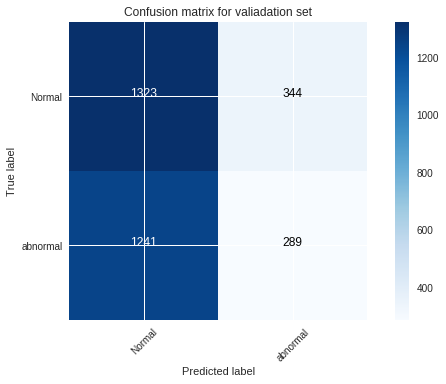

In [0]:
#@title SubModel Evaluation { form-width: "30%" }
model = 6 #@param {type:"number"}
epoch = 2 #@param {type:"integer"}
batch_size = 32 #@param {type:"integer"}

# No need now as I saved submodels and using them in ensemble model

model_file= 'model_'+ models_names[model] +'.h5'

p = mp.Process(target=watch_, args=(model_file,20))
p.start()
evaluate_limps(model=model,epoch=epoch,batch=batch_size,imagenet=True,freeze_all=True,verbose=1)


# Ensemble Model
### MobileNetV2 + DenseNet + Resnet50 (pretrained + downloaded from Dropbox)

In [0]:
# all_models = list()
# for i in listdir(dir):
 
#   if i == 'model_NASNetMobile.h5' or i == 'model_ensemble.h5':
#     continue
    
#   filename = dir + i
#   # load model from file
#   model = load_model(filename)
#   # add to list of members
#   all_models.append(model)
#   print('loaded ',filename)

# def ensemble_model(all_models):
  
#   for i in range(len(all_models)):
#     model = all_models[i]
#     for layer in model.layers:
#       # make not trainable
#       layer.trainable = False
#       # rename to avoid 'unique layer name' issue
#       layer.name = 'ensemble_' + str(i+1) + '_' + layer.name
#   # define multi-headed input
#   ensemble_visible = [model.input for model in all_models]
#   # concatenate merge output from each model
#   ensemble_outputs = [model.output for model in all_models]
#   merge = concatenate(ensemble_outputs)
#   #print(merge.shape)
#   #merge = keras.layers.Permute((2,1))(merge)
#   #merge=keras.layers.Reshape((3,),dtype=tf.float32_ref)(merge)
#   hidden = Dense(128, activation='relu')(merge)
#   output = Dense(1, activation='sigmoid')(hidden)
#   model = Model(inputs=ensemble_visible, outputs=output)
  
#   # plot graph of ensemble
#   plot_model(model, show_shapes=True, to_file='ensemble_model_graph.png')
#   # compile
#   model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#   return model

In [0]:
# @timer
# def eval_ensemble(model_file='model_ensemble.h5',epoch=3,batch=64,verbose=2):
  
  
#   df_train=pd.read_csv('train_paths_labels.csv')
#   df_valid=pd.read_csv('valid_paths_labels.csv')
  
#   datagen=ImageDataGenerator(rescale=1./255)
#   train_generator=datagen.flow_from_dataframe(dataframe=df_train, directory=None,x_col="Img_Path", y_col="Label", class_mode="binary",
#                                               target_size=(224,224), batch_size=batch)
#   valid_generator=datagen.flow_from_dataframe(dataframe=df_valid, directory=None,x_col="Img_Path", y_col="Label", class_mode="binary",
#                                               target_size=(224,224), batch_size=batch)
  
#   keras.backend.clear_session()
  
  
#   if not os.path.isfile(dir + model_file):
#     print("making ensemble model")
#     model = ensemble_model(all_models)
#   else:
#     print("loading saved ensemble model")
#     model= load_model(dir + model_file)
  
#   print("compiling")
#   model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  
#   checkpoint= ModelCheckpoint(dir + model_file, monitor='val_loss', verbose=1, save_best_only=False,
#                               save_weights_only=False, mode='auto', period=1)
#   callbacks_list = [checkpoint]
    
#   step_train=train_generator.n//train_generator.batch_size
#   step_valid=valid_generator.n//valid_generator.batch_size
  
#   model.fit_generator(generator=train_generator, steps_per_epoch=step_train, epochs=epoch, validation_data=valid_generator,
#                       validation_steps=step_valid, shuffle=True, verbose=verbose, callbacks=callbacks_list)
  
  
  
#   loss_tr, accuracy_tr = model.evaluate_generator(train_generator, use_multiprocessing=True,workers=5,steps=step_train)
#   print("training loss/accuracy: ", loss_tr,'/', accuracy_tr)

#   loss_val, accuracy_val = model.evaluate_generator(valid_generator, use_multiprocessing=True,workers=5,steps=step_valid)
#   print("validation loss/accuracy: ", loss_val,'/', accuracy_val)
  

In [0]:
# #@title SubModel Evaluation { form-width: "30%" }
# epoch = 3 #@param {type:"integer"}
# batch_size = 64 #@param {type:"integer"}

# model_file= 'model_ensemble.h5'

# p = mp.Process(target=watch_, args=(model_file,20))
# p.start()
# eval_ensemble(model_file=model_file,epoch=3,batch=batch_size,verbose=1)